# Predict Titanic survival by logistic recession, random forest & XGBoost

# Background

Titanic was, not only a romantic symbol by the story between Jack and Rose, but also one of the most infamous shipwrecks in history.

On April 15, 1912, Titanic, with a designation “unsinkable ship” sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

Then, the next question will be “what sorts of people were more likely to survive?” by analyzing the passenger data (eg name, age, gender, socio-economic class, etc).

# Hypothesis

The "women and children first" protocol was generally followed when loading the lifeboats, so it is predicted that female, child and elderly will have more chances to get into lifeboats.

For the location, Titanic can be divided into several cabins to serve different classes. In general, first class should be located in upper deck with the best view. Passingers in lower deck will have least time to escape during water influx. Many of them were probably trapped and died. Thus, class level and the location of passengers when colliding with an iceberg are another key points of survival.

# Data preparation

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [11]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# Age

In [17]:
import matplotlib.pyplot as plt

In [26]:
Age = df_train.groupby('Age')['Survived'].mean().reset_index()

The graph is in a concave shape: aged below 15 and above 50 have higher survival rate

Text(0, 0.5, 'Mean of survival')

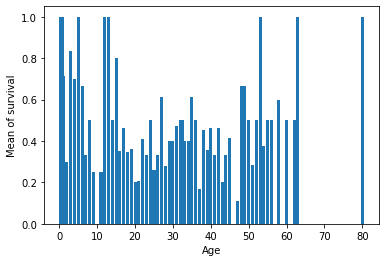

In [31]:
plt.bar(Age['Age'],Age['Survived'])
plt.xlabel("Age")
plt.ylabel("Mean of survival")

In [8]:
#Rounding the original age to nearest integer
df_train['age'] = round(df_train['Age'].fillna(0)).astype(int)

# Gender

Female has higher survival rate than male, nearly 4 times.

In [27]:
df_train.groupby('Sex')['Survived'].agg(['sum','count','mean','std'])

,sum,count,mean,std
Sex,,,,
female,233,314,0.742038,0.438211
male,109,577,0.188908,0.391775


# No of direct relatives aboard the Titanic

dictionary of dataset:

sibsp --> Number of siblings/spouses aboard the Titanic

parch --> Number of parents/children aboard the Titanic

Assumption:
Having direct relatives aboard the Titanic will trigger their willpower to live, Or,
the captain will allow those with direct relatives escape first,
resulting in higher survival rate

Having no or only one sibsp are the majority. Having 1 or 2 sibsp have higher survival rate than passengers with no sibsp.

In [37]:
df_train.groupby('SibSp')['Survived'].agg(['sum','count','mean','std'])

,sum,count,mean,std
SibSp,,,,
0,210,608,0.345395,0.475888
1,112,209,0.535885,0.499908
2,13,28,0.464286,0.507875
3,4,16,0.250000,0.447214
4,3,18,0.166667,0.383482
5,0,5,0.000000,0.000000
8,0,7,0.000000,0.000000


Similarly, having no or only one parch are the majority. Having 1 or 2 parents have higher survival rate than passengers with no parent.

In [38]:
df_train.groupby('Parch')['Survived'].agg(['sum','count','mean','std'])

,sum,count,mean,std
Parch,,,,
0,233,678,0.343658,0.475279
1,65,118,0.550847,0.499529
2,40,80,0.500000,0.503155
3,3,5,0.600000,0.547723
4,0,4,0.000000,0.000000
5,1,5,0.200000,0.447214
6,0,1,0.000000,NaN


If compare these 2 factors: sibsp & parch, what is the result?

Just have a look on passengers with maximun 2 sibsp/parch, as only very few passengers have more than 2 sibsp/parch.
Similarly to above observation, passengers with no sibsp and parch have lower survival rate, while passengers with at least 1 sibsp and 1 parch have higher survival rate, more than 50%.

Notably, compared to sibsp, passenegrs with at least 1 parch, even though he/she had no sibsp, have higher survival than opposite (passengers with at least 1 sibsp but no parch).

In [39]:
import seaborn as sns

In [91]:
sib_parch = df_train[['SibSp','Parch','Survived']].groupby(['SibSp','Parch'])['Survived'].mean().reset_index()

In [92]:
sib_parch.pivot(index='SibSp',columns='Parch',values='Survived')

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,0.303538,0.657895,0.724138,1.000000,0.0,0.000000,NaN
1,0.520325,0.596491,0.631579,0.333333,0.0,0.333333,0.0
2,0.250000,0.857143,0.500000,1.000000,NaN,NaN,NaN
3,1.000000,0.000000,0.285714,NaN,NaN,NaN,NaN
4,NaN,0.000000,0.333333,NaN,NaN,NaN,NaN
5,NaN,NaN,0.000000,NaN,NaN,NaN,NaN
8,NaN,NaN,0.000000,NaN,NaN,NaN,NaN


# P class

P class refers to level of cabin, close to first, business, economy class in airline.
P class 1 indicates the superior class.

Within expectation, survival rate is negatively related to the p class level, ie. smaller the no of p class, higher the survival rate.

In [55]:
df_train.groupby('Pclass')['Survived'].agg(['sum','count','mean','std'])

,sum,count,mean,std
Pclass,,,,
1,136,216,0.629630,0.484026
2,87,184,0.472826,0.500623
3,119,491,0.242363,0.428949


Fare is another feature in the dataset, however, it is actually closely associated with the level of p class.

Below figure shows that fare of p class 2 & 3 are under 100 dollars. As for fare above 100 dollars, all of them refer to p class 1.

Text(0, 0.5, 'Fare amount')

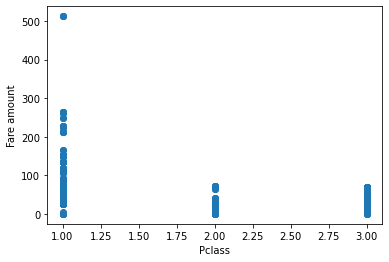

In [21]:
plt.scatter(df_train['Pclass'],df_train['Fare'])
plt.xlabel('Pclass')
plt.ylabel('Fare amount')

# Modelling by logistic regression

In [4]:
#create new column of binary variable representing gender 
df_train['Gender']=0
df_train.loc[df_train['Sex']=='female','Gender']=1

In [5]:
#extract first letter of cabin to identify the location of passengers when sinking
df_train['Cabin_code']=df_train['Cabin'].str[0]

In [14]:
df_train.Cabin_code.unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [6]:
#one hot encoding for Embarked, and Cabin code
dummies_1 = pd.get_dummies(df_train.Embarked)
dummies_2 = pd.get_dummies(df_train.Cabin_code)

In [25]:
dummies_1

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [16]:
dummies_2

,A,B,C,D,E,F,G,T
0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0
887,0,1,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0
889,0,0,1,0,0,0,0,0


In [9]:
features = df_train[['Pclass','Gender','age','SibSp','Parch']]

In [67]:
#Check whether there is missing value
features.isna().sum()

Pclass    0
Gender    0
age       0
SibSp     0
Parch     0
dtype: int64

In [10]:
X = pd.concat([features,dummies_1,dummies_2],axis='columns')

In [11]:
y = df_train['Survived']

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
#Split train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=46)

In [74]:
from sklearn.linear_model import LogisticRegression

In [80]:
model = LogisticRegression()

model.fit(X_train,y_train)

predicted_y = model.predict(X)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
#accuracy of model using train file
model.score(X_train,y_train)

0.8019662921348315

# Validation

In [82]:
predictions = model.predict(X_valid)

Confusion matrix tabulate the number of misclassifications. 
Below is the description of different locations in confusion matrix:

[[True positive (TP), False positive (FP)],

[False negative (FN), True negative (TN)]]

No of false negative is lightly larger than false positive, meaning that the model has higher likelihood to predict an alive passenger to be dead.

In [83]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid,predictions)

array([[96,  8],
       [20, 55]])

In [84]:
#accuracy of model using validation file
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, predictions)

0.8435754189944135

# Modelling by Random forest

validation score is similar to logistic regression

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
#accuracy of model using validation file
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_valid, y_valid)

0.8435754189944135

# Modelling by xgboost

In [1]:
import xgboost as xgb

In [41]:
#since "C" appear in both embarked and cabin, it need a prefix to make all columns unique so that xgboost model can differentiate.
dummy1 = pd.get_dummies(df_train.Embarked.reset_index()).drop(columns='index')
dummy2 = pd.get_dummies(df_train.Cabin_code.reset_index()).drop(columns='index')

In [42]:
dummy1

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [43]:
dummy2

,Cabin_code_A,Cabin_code_B,Cabin_code_C,Cabin_code_D,Cabin_code_E,Cabin_code_F,Cabin_code_G,Cabin_code_T
0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,0
887,0,1,0,0,0,0,0,0
888,0,0,0,0,0,0,0,0
889,0,0,1,0,0,0,0,0


In [45]:
X = pd.concat([features,dummy1,dummy2],axis='columns')
y = df_train['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=46)

In [61]:
from xgboost import XGBClassifier

In [62]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier()

Without tuning the hyperparameter, the accuracy is already higher than logistic regression and random forest.

In [63]:
xgb.score(X_valid, y_valid)

0.8491620111731844

In [65]:
xgb_prediction = xgb.predict(X_valid)

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid,xgb_prediction)

array([[98,  6],
       [21, 54]])